<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Image Classification using CNNs
**Notes:**  
- This notebook should be run on GPU.

In [ ]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = '2_computer_vision/CNNs'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Load training and test data
if not os.path.exists('./data'):
    os.mkdir('./data')

# Set up transforms - ToTensor only in this case
data_transform = transforms.Compose([transforms.ToTensor()]) # Converts pixel values to tensor in range [0.,1.]

# Set up datasets
train_data = FashionMNIST(root='data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='data', train=False,
                                  download=True, transform=data_transform)

print('Training data images: ', len(train_data))
print('Test data images: ', len(test_data))

# Specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

Training data images:  60000
Test data images:  10000


### Step 1: Set up dataloaders for our data

In [3]:
batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

torch.Size([16, 1, 28, 28])


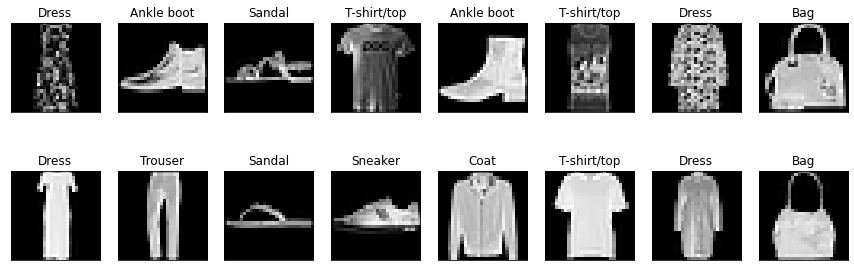

In [4]:
# Get next batch of training images
images, labels = iter(train_loader).next()
print(images.shape)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

As we see above, the inputs in a PyTorch DataLoader are of shape [N,C,H,W) where:  
- N = batch size  
- C = number of channels (1 for grayscale, 3 for RGB color)  
- H = image height  
- W = image width

### Step 2: Define our neural network architecture

When we create a neural network architecutre in PyTorch, we define the layers of the model in the `__init__` and define the feedforward behavior of the network in the `forward` function.  PyTorch performs the backpropagation step for us by keeping track of the network's feedforward behavior and using autograd to calculate the updates to the weights.

CNNs contain two new types of layers which we did not see in the previous examples of fully connected networks: convolutional layers and pooling layers.

A convolutional layer may be defined like this in `__init__` (convolutional layer with 1 input channel (grayscale), 32 output channels/feature maps and a 3x3 square convolution kernel):

```
self.conv1 = nn.Conv2d(1, 32, 3)
```
And a pooling layer can be defined like this, also in `__init__` (maxpool that uses a square window of kernel_size=2, stride=2):

```
self.pool = nn.MaxPool2d(2, 2)      
```

For convolutional layers, we can specify the desired number of output feature maps, and the dimensions of each feature map (width/height) can be computed as the input image width/height (W or H) minus the filter size (F) plus 2 * padding (P), divided by the stride (S) + 1. The equation to calculate the output dimensions of the convolution layer is:  
```
output_dim = (W-F+2P)/S + 1
```
 A derivation of this formula can be found [here](http://cs231n.github.io/convolutional-networks/#conv).

Pooling layers can also be thought of as a special form of filtering.  Therefore for a pooling layer, the output can be computed as the input width/height (W) minus the filter size (F) plus 2 * padding (P), divided by the stride (S) + 1.  The equation to calculate the output shape of the pooling layer is:  
```
output_dim = (W-F+2P)/S + 1
```
Generally padding is not applied for pooling layers.  We take the floor of the above function in the event that the output_dim is not an integer (meaning we round it down to the nearest integer).

It is common practice to feed the outputs of the convolutional & pooling layers into a final fully connected linear layer.  Prior to feeding the conv/pooling outputs into the linear layer, we must first flatten the eatures into a vector. In PyTorch we can flatten an input `x` by using `x = x.view(x.size(0), -1)`.

Finally, depending on our task we apply a final activation layer (e.g. softmax) to convert the outputs from the linear layer into class scores.  Note that some loss functions (e.g. CrossEntropy loss) include the softmax so we do not need to define it separately in the neural network architecture.

In [5]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        #Input shape: (batch_size,1,28,28)
        
        # Convolutional 1 layer: 3x3 kernel, stride=1, padding=0, 10 output channels / feature maps
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=0)
        # Conv1 layer output size = (W-F+2P)/S+1 = (28-3)/1+1 = 26
        # Conv1 layer output shape for one image: [10,26,26]
        
        # Maxpool layer: kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool output shape for one image: [10,13,13]
        
        # Convolutional 2 layer: 3x3 kernel, stride=1, padding=0, 20 output channels / feature maps
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3, stride=1, padding=0)
        # Conv2 layer output size = (W-F+2P)/S+1 = (13-3)/1+1 = 11
        # Conv2 layer output shape for one image: [20,11,11]
        
        # Maxpool layer: kernel_size=2, stride=2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool output shape for one image: [20,5,5]
        
        # Input size: 20 * 5 * 5 = 500 from pool2 pooling layer
        # 10 output channels (for the 10 classes)
        self.fc1 = nn.Linear(20*5*5, 10)
        
    def forward(self, x):
        # Two convolutional layers followed by relu and then pooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten into a vector to feed into linear layer
        x = x.view(x.size(0), -1)
        
        # Linear layer
        x = self.fc1(x)
        
        return x


In [6]:
# Instantiate the model
net = ConvNet()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 10, 26, 26]             100
         MaxPool2d-2           [16, 10, 13, 13]               0
            Conv2d-3           [16, 20, 11, 11]           1,820
         MaxPool2d-4             [16, 20, 5, 5]               0
            Linear-5                   [16, 10]           5,010
Total params: 6,930
Trainable params: 6,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.39
Params size (MB): 0.03
Estimated Total Size (MB): 1.46
----------------------------------------------------------------


### Step 3: Define a cost / loss function and optimizer

In [7]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

### Step 4: Train the model
To train our model, we perform the following four steps in a loop, using one input mini-batch at a time:  
    1) Make a forward pass through the network to calculate the network output  
    2) Use the network output to calculate the cost/loss  
    3) Calculate the gradient of the cost/loss with respect to the weights by performing a backward pass through the network with loss.backward()  
    4) Update the weights by taking a step with the optimizer

If GPU is available, we can move the model (all its parameter Tensors) onto GPU. If we decided to use GPU, we also need to put all the data Tensors used in training onto GPU.

In [8]:
def train_model(model,criterion,optimizer,train_loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()
            
            if i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {:.4f}'.format(epoch + 1, i+1, avg_loss))
                running_loss = 0.0

    return loss_over_time



Epoch: 1, Batch: 1000, Avg. Loss: 1.2220
Epoch: 1, Batch: 2000, Avg. Loss: 0.6762
Epoch: 1, Batch: 3000, Avg. Loss: 0.5980
Epoch: 2, Batch: 1000, Avg. Loss: 0.5292
Epoch: 2, Batch: 2000, Avg. Loss: 0.4919
Epoch: 2, Batch: 3000, Avg. Loss: 0.4683
Epoch: 3, Batch: 1000, Avg. Loss: 0.4558
Epoch: 3, Batch: 2000, Avg. Loss: 0.4460
Epoch: 3, Batch: 3000, Avg. Loss: 0.4335
Epoch: 4, Batch: 1000, Avg. Loss: 0.4092
Epoch: 4, Batch: 2000, Avg. Loss: 0.4285
Epoch: 4, Batch: 3000, Avg. Loss: 0.4058
Epoch: 5, Batch: 1000, Avg. Loss: 0.3843
Epoch: 5, Batch: 2000, Avg. Loss: 0.4059
Epoch: 5, Batch: 3000, Avg. Loss: 0.3938


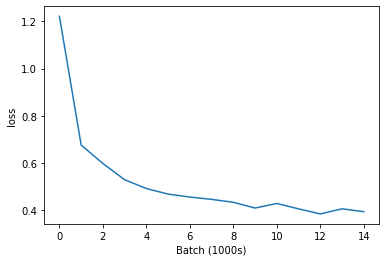

In [9]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 5
cost_path = train_model(net,criterion,optimizer,train_loader,n_epochs,device)

# visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (1000s)')
plt.ylabel('loss')
plt.show()

### Step 5: Test the model on the test set

`Model.train()` and `Model.eval()` are functions acting as a switch which turns on/off any randomness of layers in the model such as dropout which are used to improve training but which we do not want to use while testing / in production.

In [10]:
def test_model(model,test_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels.cpu().numpy())

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(10):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals



In [11]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(net,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.860
For class T-shirt/top, recall is 0.79
For class Trouser, recall is 0.965
For class Pullover, recall is 0.698
For class Dress, recall is 0.869
For class Coat, recall is 0.832
For class Sandal, recall is 0.941
For class Shirt, recall is 0.649
For class Sneaker, recall is 0.937
For class Bag, recall is 0.96
For class Ankle boot, recall is 0.961


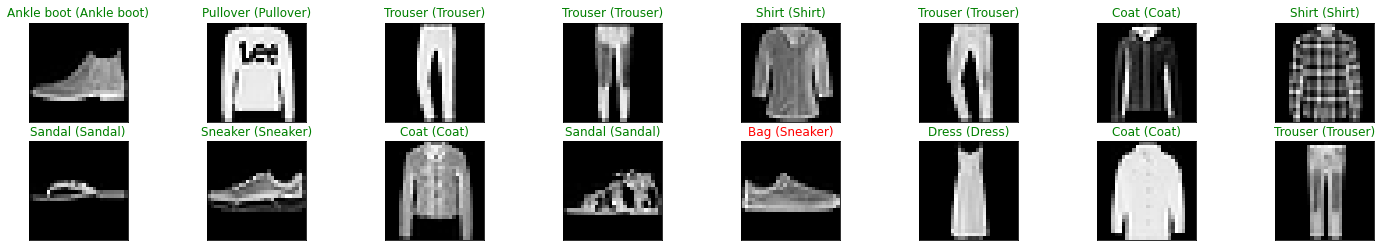

In [13]:
# Display a batch of predictions

with torch.no_grad():
    net = net.to(device)
    net.eval()
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)
    # get predictions
    preds = np.squeeze(net(images).max(1, keepdim=True)[1].cpu().numpy())
    images = images.cpu().numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Saving models
To save PyTorch models for later use, we have two options:  
1) We can save the `state_dict` which contains all the learned parameters of the model (the weights and biases) but not the architecture itself.  To use it, we instantiate a new model of the desired architecture and then load the saved `state_dict` to assign values to all the parameters in the model  
2) We can alternatively save the entire model including the architecture, and then load it up and use it for prediction

In [ ]:
# OPTION 1: Save the state dictionary of the model
import os
model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

filename = 'model_state_dict.pt'

# Save the model's learned parameters (state_dict)
torch.save(net.state_dict(), os.path.join(model_dir,filename))

In [ ]:
# Initialize new model as ConvNet() class and load state dict previously saved
model = ConvNet()
model.load_state_dict(torch.load(os.path.join(model_dir,filename)))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Test loaded model
acc,recall_vals = test_model(model,test_loader,device)
print()
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

In [ ]:
# OPTION 2: Save the entire model

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
filename = 'fullmodel.pt'

# Save the entire model
torch.save(net, os.path.join(model_dir,filename))

In [ ]:
# Load model
model2 = torch.load(os.path.join(model_dir,filename))

# Test loaded model
acc,recall_vals = test_model(model2,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))